<a href="https://colab.research.google.com/github/magalaReuben/practicaldeepreinforcementlearning/blob/main/Lecture3/DeepQLearningPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install swig
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 33.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376097 sha256=71990a0311c4b30595a5e9b39b32c7a1aa7f177bda0215f57f384b715eed2727
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random


In [29]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
print("observation_space", *env.observation_space.shape)
print("action_space", env.action_space.n)

observation_space 8
action_space 4


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import numpy as np

MEM_SIZE = 10000
BATCH_SIZE = 64

class ReplayMemory:
    def __init__(self):
        self.mem_count = 0

        self.states = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=bool)

    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE

        self.states[mem_index]  = state
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_
        self.dones[mem_index] =  1 - done

        self.mem_count += 1

    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)

        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

In [10]:
LEARNING_RATE = 0.0001

class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        # to cater for envs of different dimensions
        self.input_shape = env.observation_space.shape
        # must be a finite discrete action space
        self.action_space = env.action_space.n

        self.layer1 = nn.Linear(*self.input_shape, 1024)
        self.layer2 = nn.Linear(1024, 1024)
        self.layer3 = nn.Linear(1024, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.SmoothL1Loss()
        self.to(device)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)

        return x

In [7]:
max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.9999

gamma = 0.95

class DqnAgent:
    def __init__(self):
        self.memory = ReplayMemory()
        self.exploration_rate = max_epsilon
        self.network = DQN()

    def choose_action(self, state):
        random_num = random.uniform(0, 1)
        if random_num > self.exploration_rate:
            state = torch.tensor(state).float().detach().to(device).unsqueeze(0)
            q_values = self.network(state)
            return torch.argmax(q_values).item()
        else:
            return env.action_space.sample()

    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return

        states, actions, rewards, next_states, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.bool).to(device)
        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)

        q_values = self.network(states)
        next_q_values = self.network(next_states)

        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0]

        q_target = rewards + gamma * predicted_value_of_future * dones

        loss = self.network.loss(q_target, predicted_value_of_now)
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= decay_rate
        self.exploration_rate = max(min_epsilon, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate

Episode 1 Average Reward -109.11342192902595 Best Reward -109.11342192902595 Last Reward -109.11342192902595 Epsilon 1.0
Episode 2 Average Reward -123.72897952787804 Best Reward -109.11342192902595 Last Reward -138.34453712673013 Epsilon 0.9919323148461192
Episode 3 Average Reward -107.8119157848704 Best Reward -75.97778829885507 Last Reward -75.97778829885507 Epsilon 0.9852097216922968
Episode 4 Average Reward -97.70296621216693 Best Reward -67.3761174940565 Last Reward -67.3761174940565 Epsilon 0.9788263078961694
Episode 5 Average Reward -119.56419530276521 Best Reward -67.3761174940565 Last Reward -207.0091116651584 Epsilon 0.9714150558198451
Episode 6 Average Reward -165.6446911522007 Best Reward -67.3761174940565 Last Reward -396.04717039937816 Epsilon 0.9628073923556362
Episode 7 Average Reward -166.1883413376659 Best Reward -67.3761174940565 Last Reward -169.45024245045707 Epsilon 0.9539897468226081
Episode 8 Average Reward -156.5836591379056 Best Reward -67.3761174940565 Last R

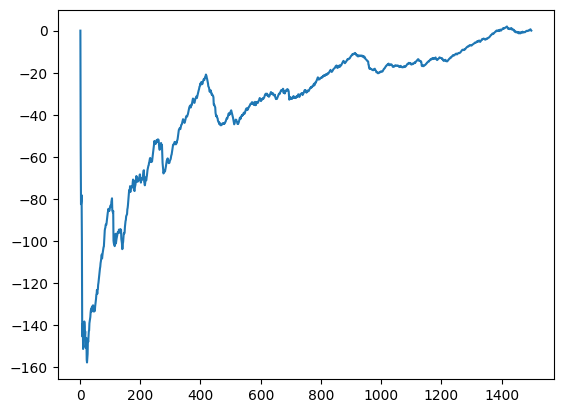

In [11]:
EPISODES = 1500
best_reward = float('-inf')
average_reward = 0
episode_number = []
average_reward_number = []
observation_space = env.observation_space.shape[0]

agent = DqnAgent()

for i in range(1, EPISODES):
    state = env.reset()[0]
    state = np.reshape(state, [1, observation_space])
    score = 0

    while True:
        #env.render()
        action = agent.choose_action(state)
        state_, reward, terminated, truncated, info = env.step(action)
        state_ = np.reshape(state_, [1, observation_space])
        agent.memory.add(state, action, reward, state_, terminated)
        agent.learn()
        state = state_
        score += reward

        if terminated:
            if score > best_reward:
                torch.save(agent.network.state_dict(), 'best_model_weights.pth')
                best_reward = score
            average_reward += score
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break

        episode_number.append(i)
        average_reward_number.append(average_reward/i)

plt.plot(episode_number, average_reward_number)
plt.show()

In [ ]:
import numpy as np
import imageio

images = []
obs = env.reset()[0]
img = env.render()
print(img)
max_steps = 50000
step = 0

agent = DqnAgent()
agent.network.load_state_dict(torch.load('best_model_weights.pth'))
state = env.reset()[0]
state = np.reshape(state, [1, observation_space])

while step < max_steps:
    action = agent.choose_action(state)
    state_, reward, terminated, truncated, info = env.step(action)
    img = env.render()
    images.append(img)
    step += 1
    print(f"Step: {step}")

print(images)
imageio.mimsave("output.mp4", [np.array(img) for i, img in enumerate(images)], fps=60)

Streaming output truncated to the last 5000 lines.
Step: 5282
Step: 5283
Step: 5284
Step: 5285
Step: 5286
Step: 5287
Step: 5288
Step: 5289
Step: 5290
Step: 5291
Step: 5292
Step: 5293
Step: 5294
Step: 5295
Step: 5296
Step: 5297
Step: 5298
Step: 5299
Step: 5300
Step: 5301
Step: 5302
Step: 5303
Step: 5304
Step: 5305
Step: 5306
Step: 5307
Step: 5308
Step: 5309
Step: 5310
Step: 5311
Step: 5312
Step: 5313
Step: 5314
Step: 5315
Step: 5316
Step: 5317
Step: 5318
Step: 5319
Step: 5320
Step: 5321
Step: 5322
Step: 5323
Step: 5324
Step: 5325
Step: 5326
Step: 5327
Step: 5328
Step: 5329
Step: 5330
Step: 5331
Step: 5332
Step: 5333
Step: 5334
Step: 5335
Step: 5336
Step: 5337
Step: 5338
Step: 5339
Step: 5340
Step: 5341
Step: 5342
Step: 5343
Step: 5344
Step: 5345
Step: 5346
Step: 5347
Step: 5348
Step: 5349
Step: 5350
Step: 5351
Step: 5352
Step: 5353
Step: 5354
Step: 5355
Step: 5356
Step: 5357
Step: 5358
Step: 5359
Step: 5360
Step: 5361
Step: 5362
Step: 5363
Step: 5364
Step: 5365
Step: 5366
Step: 5367
Ste